## Fit a kernel to the pulsation only signal, measure accuracy

- Use S+Leaf
- Pulsation + noise
- Soho kernel(s)

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

from plot_helpers import *
plotter = PlotUtilSPLeaf()

Read the first time series

In [2]:
USE_CUDA = False
#if torch.cuda.device_count() > 0:
#    torch.cuda.set_device(0)
#    print("USE GPU")

In [3]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [4]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [5]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

Zoomed in on the first N observations

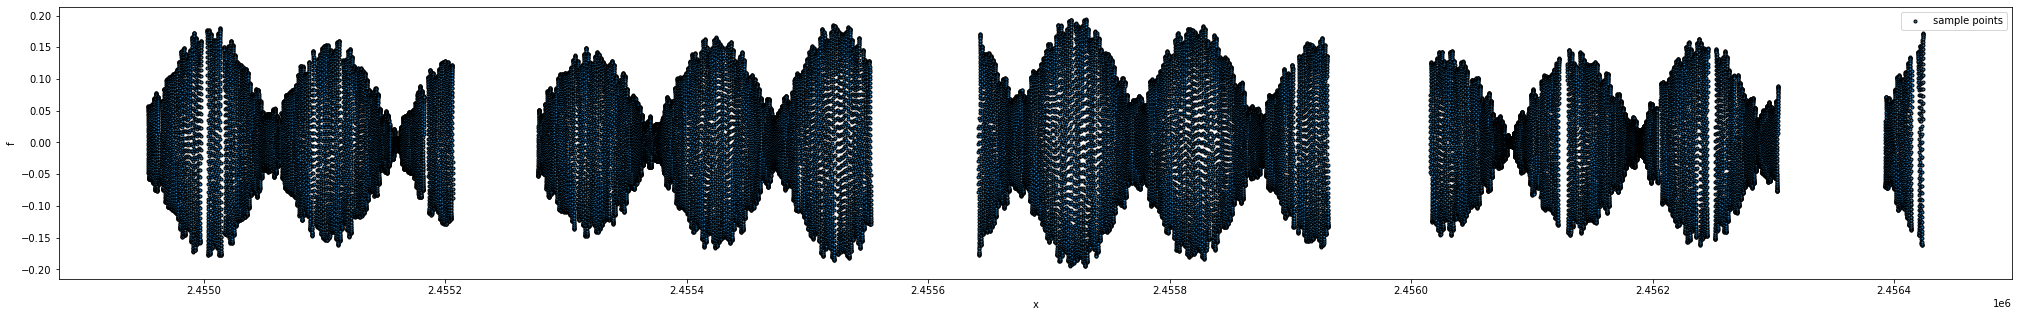

In [6]:
plotter.plot_data(X, Y)

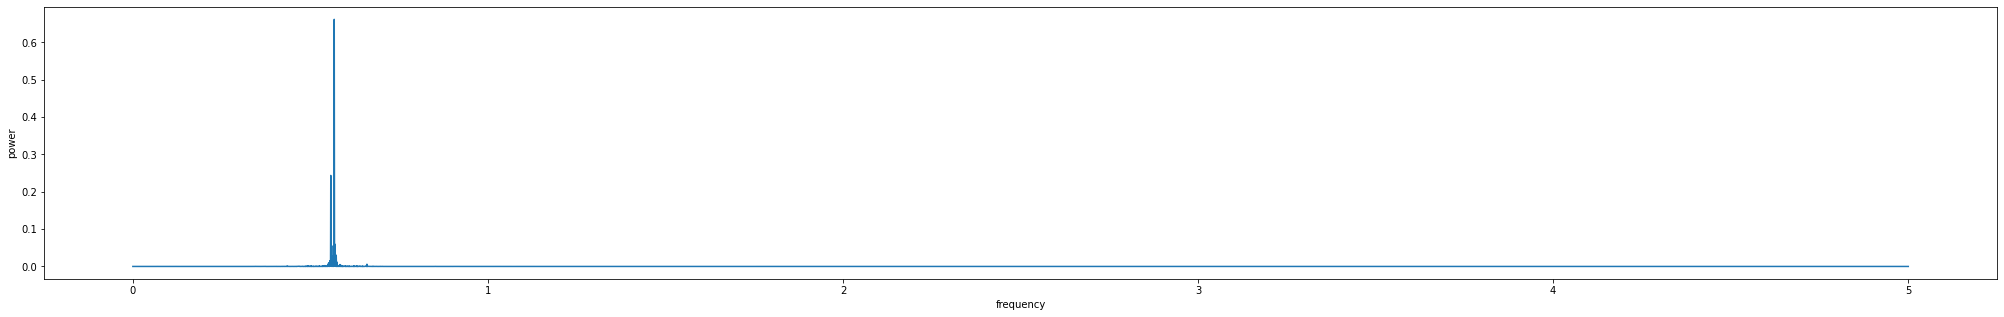

In [7]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

In [8]:
# N_part=6000
N_part=12000
# N_part=46000

In [9]:
X_part=X[:N_part]
Y_part=Y[:N_part]

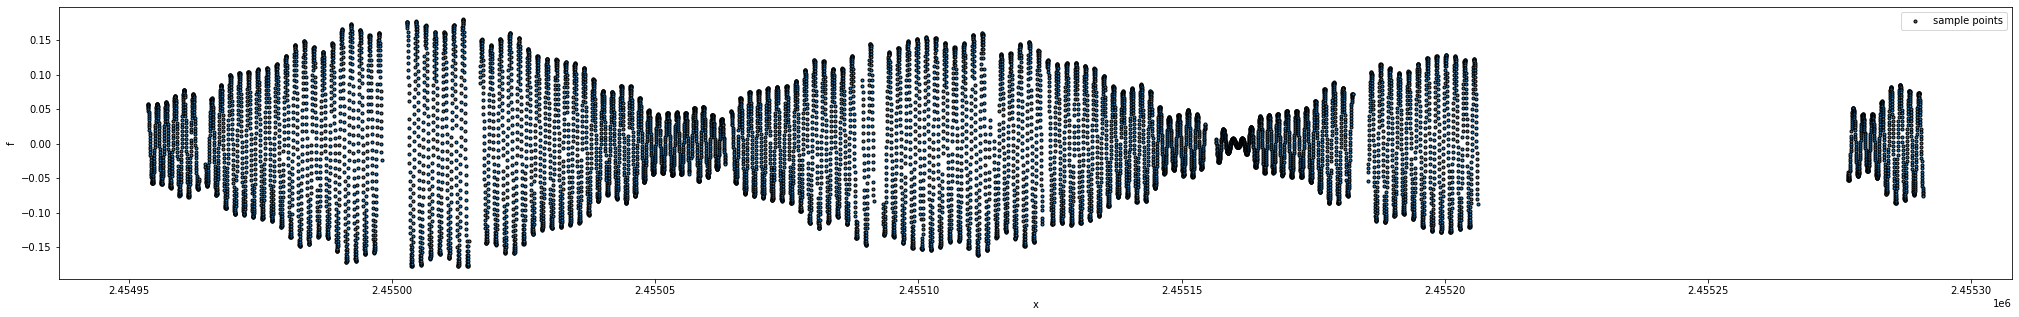

In [10]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [11]:
# normalize the data
mean, std = Y_part.mean(),Y_part.std()
Y_part = (Y_part - mean) / std

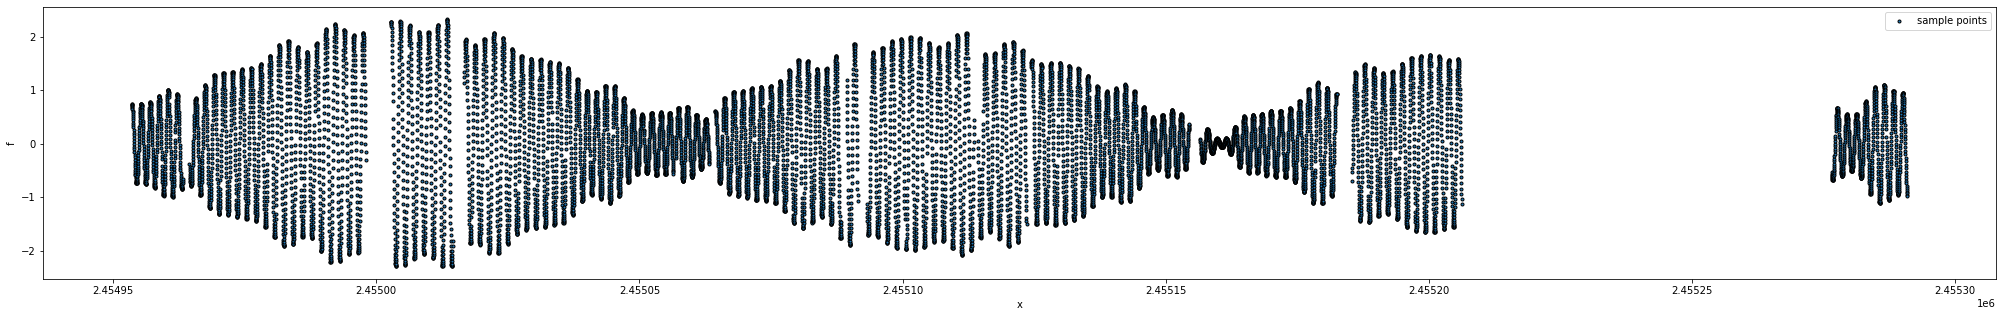

In [12]:
plotter.plot_data(X_part, Y_part)

In [13]:
# Predict evenly spaced points on our time-axis
X_part_smooth = np.linspace(X_part.min(), X_part.max(), N_part)

In [14]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [15]:
# Initialize the S+LEAF model

# Two stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# Calibration errors (correlated noise)
#calib_id = (t//1).astype(int) # One calibration per day
#caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
#yerr_calib = caliberr[calib_id]

cov_matrix = cov.Cov(X_part,
   err = term.Error(1),
   sho = term.SHOKernel(sig=-0.04314, P0=1.7474, Q=8019.36505),
   sho2 = term.SHOKernel(sig=-0.04314, P0=1.0, Q=8019.36505),
   sho3 = term.SHOKernel(sig=-0.04314, P0=1.2, Q=8019.36505),
   sho4 = term.SHOKernel(sig=-0.04314, P0=1.1, Q=8019.36505),             
   sho5 = term.SHOKernel(sig=-0.04314, P0=1.3, Q=8019.36505))
#   calerr = term.CalibrationError(calib_id, yerr_calib),

In [16]:
# List of parameters to fit: all (for now)
params_to_fit = cov_matrix.param

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix, params_to_fit))

# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
mu_part_smooth, var_part_smooth = cov_matrix.conditional(Y_part, X_part_smooth, calc_cov='diag')
Y_part_pred, var_part = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

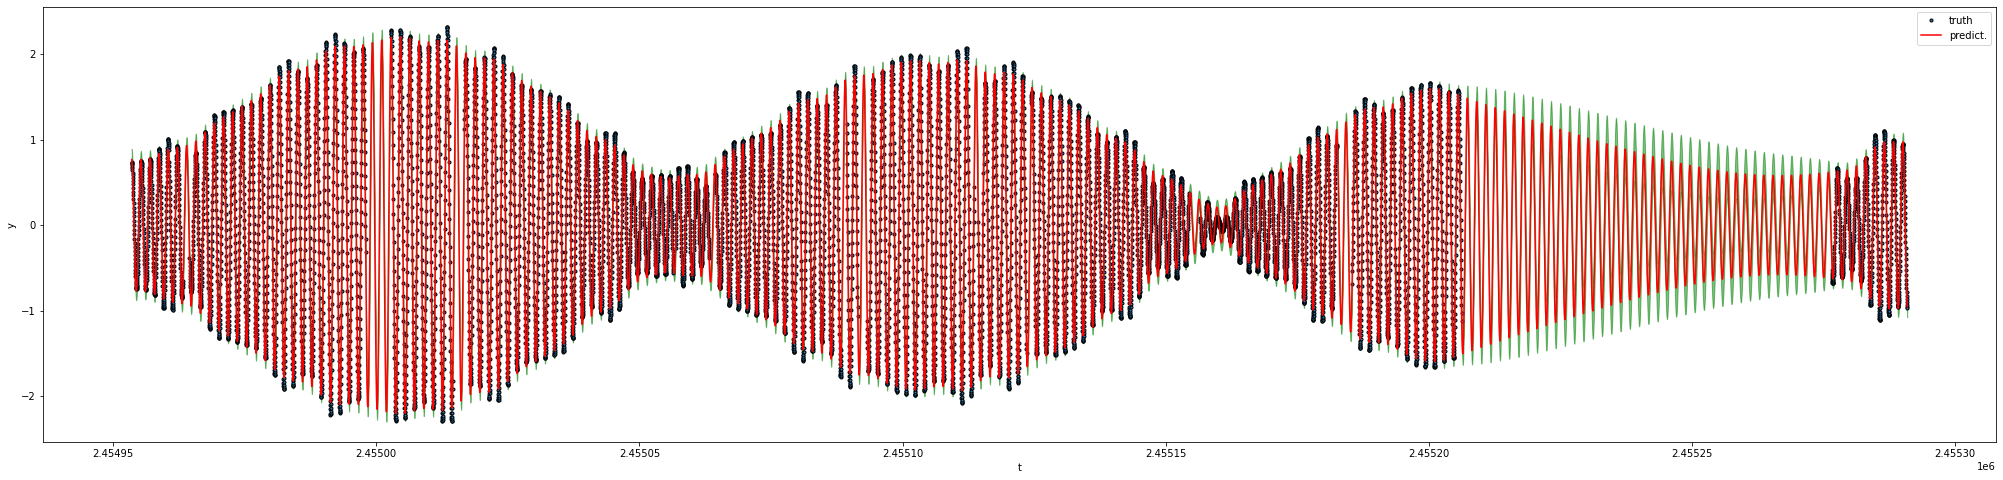

In [17]:
plotter.plot_series(X_part, Y_part, X_part_smooth, mu_part_smooth, var_part_smooth)

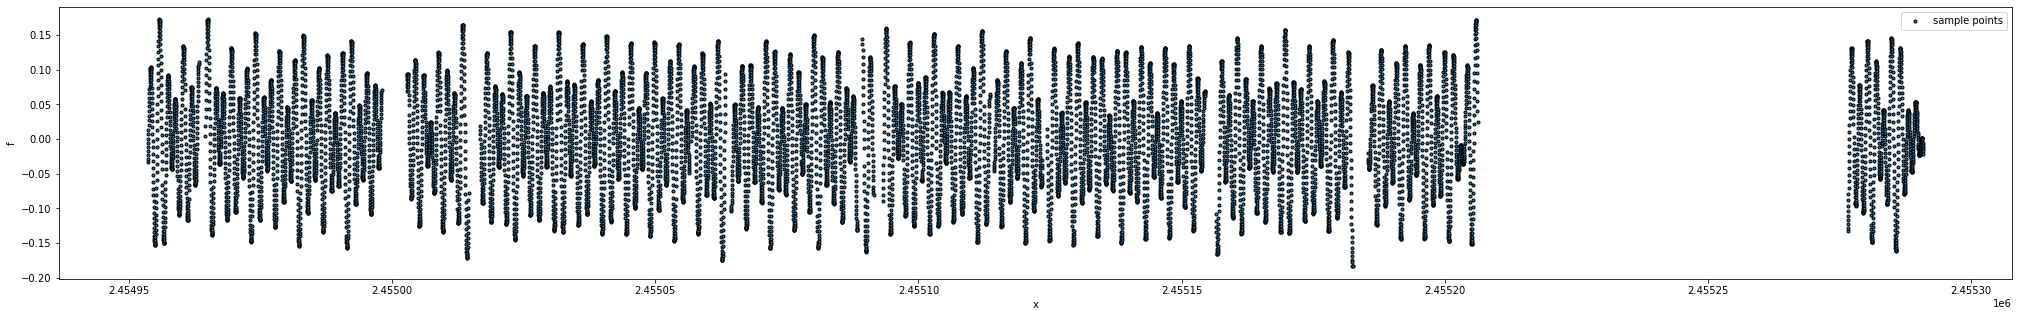

In [18]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_part_pred
plotter.plot_data(X_part, residuals)

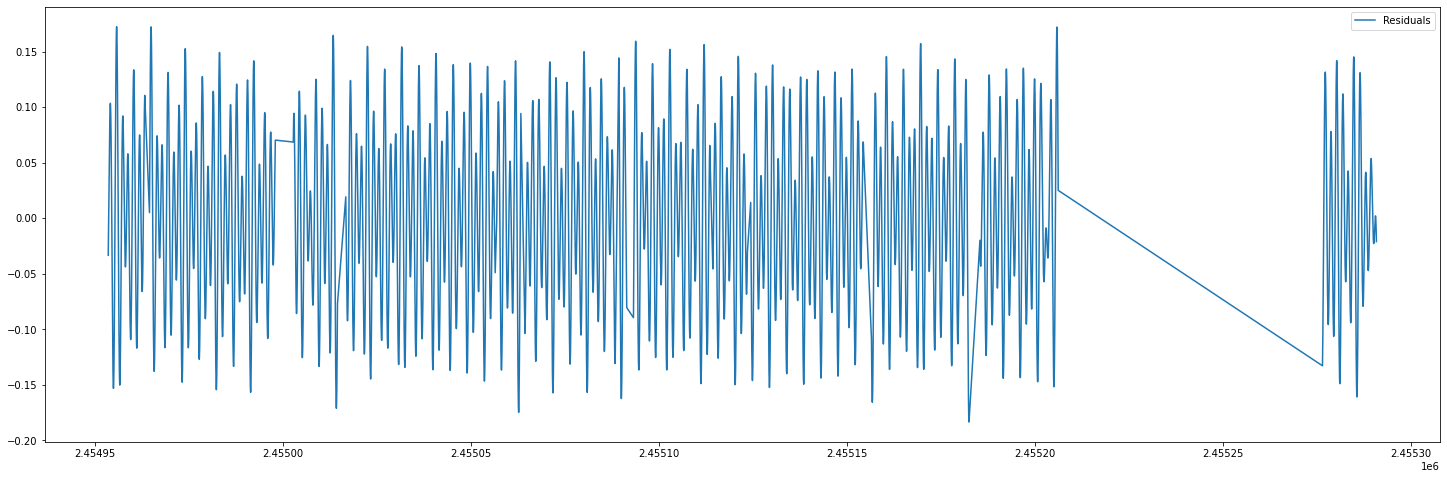

In [19]:
# Plot GP residuals
plt.figure(figsize=(25, 8))
plt.plot(X_part, residuals, "-")
plt.legend(labels=["Residuals"])

# Correlation between the original data and the fitted data

In [20]:
ts_orig = pd.DataFrame()
ts_orig['signal'] = Y_part
ts_fitted = pd.DataFrame()
ts_fitted['signal'] = Y_part_pred

In [21]:
ts_orig.corrwith(ts_fitted)

signal   0.9970606216119604
dtype: float64

In [22]:
# Trial 1: 0.9996141312510112 correlation, 50 iterations, length scale: 0.8564778816833526
# Trial 2: 0.9996349929097408 correlation, 100 iterations, length scale: 0.9996349929097408

# Conclusion:
#    100 iterations results in a slightly higher correlation. Note: depends on random initialization, I have seen 0.999631 too for 50 iterations.
#    TODO: Compare two timeseries visually, my guess is that on the one with 50 iterations does not reach the crests and throughs of the sine waves.